In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import random

In [5]:
from totalface.model_zoo.model_common import load_onnx
from totalface.model_zoo.get_models import get_detection_model,get_landmark_model
from totalface.face.get_result import get_detection, get_landmark
from totalface.data import read_image
from totalface.utils.util_landmark import recon_vers

In [6]:
from utils.aux_functions import shape_to_landmarks,get_six_points,read_cfg,color_the_mask, \
                                    get_avg_brightness, get_avg_saturation, change_brightness, change_saturation

In [7]:
def mask_face(image, face_location, six_points, angle, cfg_path, pattern,pattern_weight,color,color_weight, type="surgical",mask_base=''):
    
    debug = False

    # Find the face angle
    threshold = 13
    if angle < -threshold:
        type += "_right"
    elif angle > threshold:
        type += "_left"

    face_height = face_location[2] - face_location[0]
    face_width = face_location[1] - face_location[3]

    # Read appropriate mask image
    w = image.shape[0]
    h = image.shape[1]
    if not "empty" in type and not "inpaint" in type:
        cfg = read_cfg(config_filename=cfg_path, mask_type=type, verbose=False)
    else:
        if "left" in type:
            str = "surgical_blue_left"
        elif "right" in type:
            str = "surgical_blue_right"
        else:
            str = "surgical_blue"
        cfg = read_cfg(config_filename=cfg_path, mask_type=str, verbose=False)
    temp_path = cfg.template.replace("masks/templates/",mask_base)
    img = cv2.imread(temp_path, cv2.IMREAD_UNCHANGED)

    # Process the mask if necessary
    if pattern:
        # Apply pattern to mask
        img = texture_the_mask(img, pattern, pattern_weight)

    if color:
        # Apply color to mask
        img = color_the_mask(img, color, color_weight)

    mask_line = np.float32(
        [cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]
    )
    # Warp the mask
    M, mask = cv2.findHomography(mask_line, six_points)
    dst_mask = cv2.warpPerspective(img, M, (h, w))
    dst_mask_points = cv2.perspectiveTransform(mask_line.reshape(-1, 1, 2), M)
    mask = dst_mask[:, :, 3]
    face_height = face_location[2] - face_location[0]
    face_width = face_location[1] - face_location[3]
    image_face = image[
        face_location[0] + int(face_height / 2) : face_location[2],
        face_location[3] : face_location[1],
        :,
    ]

    image_face = image

    # Adjust Brightness
    mask_brightness = get_avg_brightness(img)
    img_brightness = get_avg_brightness(image_face)
    delta_b = 1 + (img_brightness - mask_brightness) / 255
    dst_mask = change_brightness(dst_mask, delta_b)

    # Adjust Saturation
    mask_saturation = get_avg_saturation(img)
    img_saturation = get_avg_saturation(image_face)
    delta_s = 1 - (img_saturation - mask_saturation) / 255
    dst_mask = change_saturation(dst_mask, delta_s)

    # Apply mask
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(image, image, mask=mask_inv)
    img_fg = cv2.bitwise_and(dst_mask, dst_mask, mask=mask)
    out_img = cv2.add(img_bg, img_fg[:, :, 0:3])
    if "empty" in type or "inpaint" in type:
        out_img = img_bg
    # Plot key points

    if "inpaint" in type:
        out_img = cv2.inpaint(out_img, mask, 3, cv2.INPAINT_TELEA)
        # dst_NS = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)

    if debug:
        for i in six_points:
            cv2.circle(out_img, (i[0], i[1]), radius=4, color=(0, 0, 255), thickness=-1)

        for i in dst_mask_points:
            cv2.circle(
                out_img, (i[0][0], i[0][1]), radius=4, color=(0, 255, 0), thickness=-1
            )

    return out_img, mask

In [8]:
# Load model

detection_name = "scrfd"
detection_path = "scrfd_10g_bnkps.onnx"
# Set parameters
detection_thresh = 0.5
detection_height_min=0 
detection_model = get_detection_model(detection_name,detection_path,load_multi=False)

providers: ['CUDAExecutionProvider']
scrfd onnx loaded


In [ ]:
landmark_name='3ddfa'
landmark_path = '3ddfa_v2.onnx'
landmark_model = get_landmark_model(landmark_name,landmark_path)

In [108]:
img_path = "test_1.jpg"
img = read_image(img_path)

In [115]:
mask_types=["surgical", "N95", "KN95", "cloth", "gas", "inpaint", "random", "all"]
available_mask_types=['surgical','cloth']
#mask_type = random.choice(available_mask_types)

cfg_path = "masks/masks.cfg"
mask_base = "masks/templates/"
pattern=""
pattern_weight=0.5
color=""#"#0473e2"
color_weight=0.5

In [109]:
faces = get_detection(detection_name,detection_model,img,thresh=detection_thresh)
faces, param_lst, roi_box_lst = get_landmark(landmark_name,landmark_model,img,faces)

In [112]:
ver_lst = recon_vers(param_lst,roi_box_lst)
lands = shape_to_landmarks(ver_lst[0])
point_result = get_six_points(lands,img)
six_points_on_face, angle = point_result

In [113]:
x1,y1,x2,y2 = np.array(faces[0]['bbox'],dtype=np.int32)
face_location = (x1,x2,y2,y1)

In [124]:
for mtype in available_mask_types:
    image, mask_binary = mask_face(img,face_location,six_points_on_face,angle,cfg_path,pattern,pattern_weight,color,color_weight,mtype,mask_base)
    print(mtype)

surgical
cloth


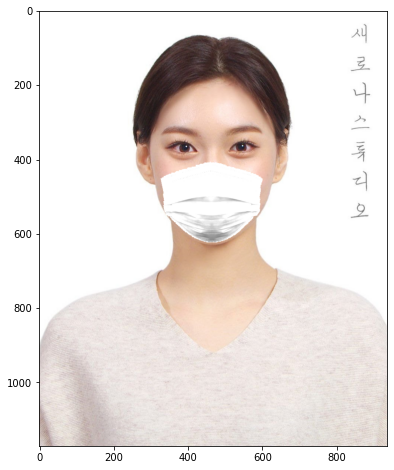

In [123]:
plt.figure(figsize=(8,8,))
plt.imshow(image)

In [125]:
# dir inference

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import random
from tqdm import tqdm

In [16]:
from totalface.model_zoo.model_common import load_onnx
from totalface.model_zoo.get_models import get_detection_model,get_landmark_model
from totalface.face.get_result import get_detection, get_landmark
from totalface.data import read_image
from totalface.utils.util_landmark import recon_vers

In [17]:
from utils.aux_functions import shape_to_landmarks,get_six_points,read_cfg,color_the_mask, \
                                    get_avg_brightness, get_avg_saturation, change_brightness, change_saturation

In [18]:
def mask_face(image, face_location, six_points, angle, cfg_path, pattern,pattern_weight,color,color_weight, type="surgical",mask_base=''):
    
    debug = False

    # Find the face angle
    threshold = 13
    if angle < -threshold:
        type += "_right"
    elif angle > threshold:
        type += "_left"

    face_height = face_location[2] - face_location[0]
    face_width = face_location[1] - face_location[3]

    # Read appropriate mask image
    w = image.shape[0]
    h = image.shape[1]
    if not "empty" in type and not "inpaint" in type:
        cfg = read_cfg(config_filename=cfg_path, mask_type=type, verbose=False)
    else:
        if "left" in type:
            str = "surgical_blue_left"
        elif "right" in type:
            str = "surgical_blue_right"
        else:
            str = "surgical_blue"
        cfg = read_cfg(config_filename=cfg_path, mask_type=str, verbose=False)
    temp_path = cfg.template.replace("masks/templates/",mask_base)
    img = cv2.imread(temp_path, cv2.IMREAD_UNCHANGED)

    # Process the mask if necessary
    if pattern:
        # Apply pattern to mask
        img = texture_the_mask(img, pattern, pattern_weight)

    if color:
        # Apply color to mask
        img = color_the_mask(img, color, color_weight)

    mask_line = np.float32(
        [cfg.mask_a, cfg.mask_b, cfg.mask_c, cfg.mask_f, cfg.mask_e, cfg.mask_d]
    )
    # Warp the mask
    M, mask = cv2.findHomography(mask_line, six_points)
    dst_mask = cv2.warpPerspective(img, M, (h, w))
    dst_mask_points = cv2.perspectiveTransform(mask_line.reshape(-1, 1, 2), M)
    mask = dst_mask[:, :, 3]
    face_height = face_location[2] - face_location[0]
    face_width = face_location[1] - face_location[3]
    image_face = image[
        face_location[0] + int(face_height / 2) : face_location[2],
        face_location[3] : face_location[1],
        :,
    ]

    image_face = image

    # Adjust Brightness
    mask_brightness = get_avg_brightness(img)
    img_brightness = get_avg_brightness(image_face)
    delta_b = 1 + (img_brightness - mask_brightness) / 255
    dst_mask = change_brightness(dst_mask, delta_b)

    # Adjust Saturation
    mask_saturation = get_avg_saturation(img)
    img_saturation = get_avg_saturation(image_face)
    delta_s = 1 - (img_saturation - mask_saturation) / 255
    dst_mask = change_saturation(dst_mask, delta_s)

    # Apply mask
    mask_inv = cv2.bitwise_not(mask)
    img_bg = cv2.bitwise_and(image, image, mask=mask_inv)
    img_fg = cv2.bitwise_and(dst_mask, dst_mask, mask=mask)
    out_img = cv2.add(img_bg, img_fg[:, :, 0:3])
    if "empty" in type or "inpaint" in type:
        out_img = img_bg
    # Plot key points

    if "inpaint" in type:
        out_img = cv2.inpaint(out_img, mask, 3, cv2.INPAINT_TELEA)
        # dst_NS = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)

    if debug:
        for i in six_points:
            cv2.circle(out_img, (i[0], i[1]), radius=4, color=(0, 0, 255), thickness=-1)

        for i in dst_mask_points:
            cv2.circle(
                out_img, (i[0][0], i[0][1]), radius=4, color=(0, 255, 0), thickness=-1
            )

    return out_img, mask

In [ ]:
# Load model

detection_name = "scrfd"
detection_path = "scrfd_10g_bnkps.onnx"
# Set parameters
detection_thresh = 0.5
detection_height_min=0 
detection_model = get_detection_model(detection_name,detection_path,load_multi=False)

landmark_name='3ddfa'
landmark_path = '3ddfa_v2.onnx'
landmark_model = get_landmark_model(landmark_name,landmark_path)

In [22]:
mask_types=["surgical", "N95", "KN95", "cloth", "gas", "inpaint", "random", "all"]
available_mask_types=['surgical','cloth']
#mask_type = random.choice(available_mask_types)

cfg_path = "masks/masks.cfg"
mask_base = "masks/templates/"
pattern=""
pattern_weight=0.5
color=""#"#0473e2"
color_weight=0.5

In [23]:
#base = "./test_images/"
#base = "./test_images2/"
base = "./test_images3/"

for img_name in tqdm(os.listdir(base)):
    if "DS" in img_name: continue
    img_path = os.path.join(base,img_name)
    img = read_image(img_path)
    
    # detect and landmarks
    faces = get_detection(detection_name,detection_model,img,thresh=detection_thresh)
    faces, param_lst, roi_box_lst = get_landmark(landmark_name,landmark_model,img,faces)
    
    # for mask
    ver_lst = recon_vers(param_lst,roi_box_lst)
    lands = shape_to_landmarks(ver_lst[0])
    point_result = get_six_points(lands,img)
    six_points_on_face, angle = point_result
    
    x1,y1,x2,y2 = np.array(faces[0]['bbox'],dtype=np.int32)
    face_location = (x1,x2,y2,y1)
    
    for mtype in available_mask_types:
        image, mask_binary = mask_face(img,face_location,six_points_on_face,angle,cfg_path,pattern,pattern_weight,color,color_weight,mtype,mask_base)
        
        s1 = "_".join(img_name.split("_")[:-1])
        s2 = img_name.split("_")[-1]
        new_name = "{}_{}_{}".format(s1,mtype,s2)
        
        new_path = os.path.join(base,new_name)
        bgr_mask = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        cv2.imwrite(new_path,bgr_mask)

100%|██████████| 196/196 [00:13<00:00, 14.85it/s]
